в потоке группировать не получится. я загружаю это всё в оперативку. всё, что ниже съедает 600мб
<br> еслиб не пункт "В" оно бы вообще и 200 обошлось
<br> выполяется чуть меньше минуты

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
t = pd.read_csv('/home/lk/competitions/household_power_consumption.txt', sep = ';')
columns_for_count = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']



/home/lk/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## A
объединить колонки дата/время в единую колонку

In [3]:
t['datetime'] = t['Date'] +' ' + t['Time']
t[:3]
#вот там в конце)

Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  \
0           18.400          0.000          1.000            17.0   
1           23.000          0.000          1.000            16.0   
2           23.000          0.000          2.000            17.0   

              datetime  
0  16/12/2006 17:24:00  
1  16/12/2006 17:25:00  
2  16/12/2006 17:26:00

## Б
оставить только колонки: дата/время (из пункта а), sub_metering_1, sub_metering_2, sub_metering_3


In [4]:
t = t[['Date','datetime','Sub_metering_1','Sub_metering_2','Sub_metering_3']]
# дата мне нужна для дальнейшей группировки. не парсить же потом ее обратно
t[:3]

Date             datetime Sub_metering_1 Sub_metering_2  \
0  16/12/2006  16/12/2006 17:24:00          0.000          1.000   
1  16/12/2006  16/12/2006 17:25:00          0.000          1.000   
2  16/12/2006  16/12/2006 17:26:00          0.000          2.000   

   Sub_metering_3  
0            17.0  
1            16.0  
2            17.0

## В
заменить пропущенные значения на среднее за некоторый период (например, -1 день - +1 день)

In [5]:
t['Date'] = t['Date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))
nuns = t[t.isna().any(axis = 1)] 
nuns[:3]
#зачем вообще эти строки. они же совсем пустые. только портить всё будут

#внезапно видим, что отсутствие значения может обозначаться "?"

#придется еще поискать. у меня оно так искалось минут 5..
#q = t[t.apply(lambda x: '?' in list(x), axis = 1)]
#all(q.index == nuns.index)
#фух они в одних и тез же местах. можно это не запускать
#del(q)   
    

Date             datetime Sub_metering_1 Sub_metering_2  \
6839  2006-12-21  21/12/2006 11:23:00              ?              ?   
6840  2006-12-21  21/12/2006 11:24:00              ?              ?   
19724 2006-12-30  30/12/2006 10:08:00              ?              ?   

       Sub_metering_3  
6839              NaN  
6840              NaN  
19724             NaN

In [6]:
t = t.dropna()
#нужно привести всё к одному типу, а эти вопросительные знаки всё портят. поэтому дропаем. потом зааппендим
for name in columns_for_count:
    t[name] = t[name].astype('float')

# даты с нулевыми значениями повторяются. если мы не учитываем часы, то можно сэкономить на повторениях дня
date_nuns = pd.DataFrame(nuns['Date'].drop_duplicates())

# придется сделать селект для каждого интервала и посчитать мин для каждой колонки.
t.index = t['Date']
date_nuns = date_nuns.join(pd.DataFrame(columns=columns_for_count))
def fill_mean_period(row, days = 1):
#     тут селект и мин
    r = t.loc[row['Date'] - timedelta(days=days) :row['Date'] +  timedelta(days=days)].mean()
    for name in columns_for_count:
        row[name] = r[name]
    return row

# заполняем значения для каждой даты
date_nuns = date_nuns.apply(fill_mean_period,axis=1)
date_nuns[:3]




Date  Sub_metering_1  Sub_metering_2  Sub_metering_3
6839  2006-12-21        1.138490        1.301760        8.248031
19724 2006-12-30        1.001390        3.103289        7.019685
41832 2007-01-14        2.473258        2.183144        9.140773

In [7]:
nuns = nuns.drop(columns_for_count,1)
# хорошо, что нулевая вся строка. можно просто смерджить по дате.
date_nuns = nuns.merge(date_nuns, on = 'Date')
# аппендим бывшие нулевые в сет
t = t.append(date_nuns)
date_nuns[:3]


Date             datetime  Sub_metering_1  Sub_metering_2  \
0 2006-12-21  21/12/2006 11:23:00         1.13849        1.301760   
1 2006-12-21  21/12/2006 11:24:00         1.13849        1.301760   
2 2006-12-30  30/12/2006 10:08:00         1.00139        3.103289   

   Sub_metering_3  
0        8.248031  
1        8.248031  
2        7.019685

## Г
обобщить данные по дням - получатся поля: дата, сумма sub_metering_1 за день, сумма sub_metering_2 за день, сумма sub_metering_3 за день

In [8]:
grouped = t.groupby('Date').sum()
grouped[:4]

Sub_metering_1  Sub_metering_2  Sub_metering_3
Date                                                      
2006-12-16             0.0           546.0          4926.0
2006-12-17          2033.0          4187.0         13341.0
2006-12-18          1063.0          2621.0         14018.0
2006-12-19           839.0          7602.0          6197.0



## Д
нарисовать график, ось x - дни, ось y - графики по сумме sub_metering_1, 2, 3 на одном графике разными цветами

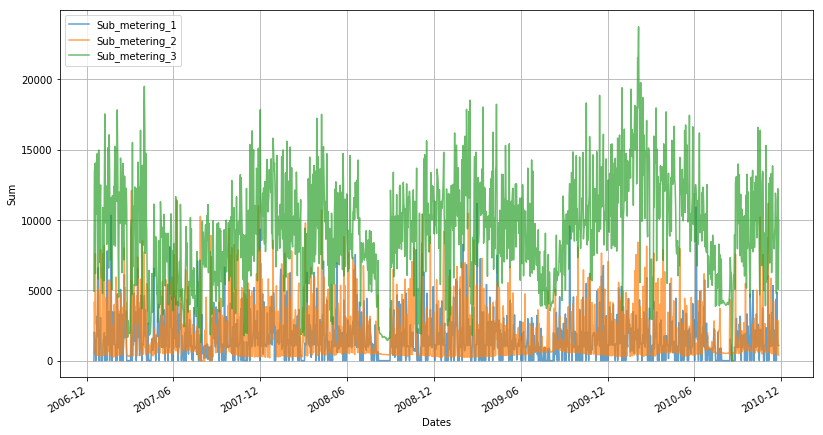

In [9]:
grouped = grouped.reset_index()
fig, ax = plt.subplots()
fig.set_size_inches(13.5, 7.5)

for name in columns_for_count:
    gtemp = grouped[['Date',name]]   
    ax.plot(gtemp['Date'], gtemp[name], label=name, alpha=0.7)
ax.legend(loc='upper left')
ax.set_xlabel('Dates')
ax.set_ylabel('Sum')
fig.autofmt_xdate()
plt.grid(True)
plt.show()